In [1]:
import numpy as np
import get_RF
import readProfile # function to read .pro file
import plt_RF
import joblib
import datetime 
import pandas as pd
import matplotlib.pyplot as plt

## load RF model

In [2]:
#%% load RF model
feature_names = ['viscdefrate', 'rcflat', 'sphericity', 'grainsize', 'penetrationdepth','slab_rhogs']  

# This model was developed using Python 3.7.4 and scikit.learn version 0.22.1
model  = joblib.load('../RF_instability_model.sav')

### EXAMPLE 1: calculate and plot the RF output probability of instability (P_unstable) given a single profile

Reading file:  ../input_example/WFJ2_2017.pro


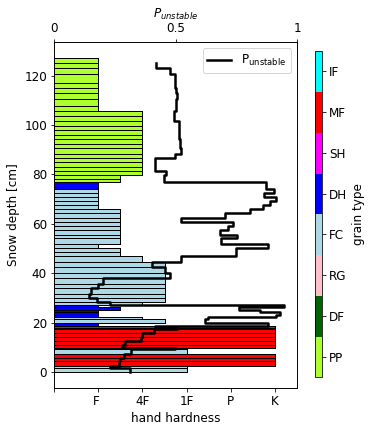

In [3]:


filename = '../input_example/WFJ2_2017.pro'
timestamp = datetime.datetime(2017,2,1,11,0)  #(year, month, day, hour, minute)

#get data from .pro 
prof = readProfile.read_profile(filename,timestamp,remove_soil=True) 


# get P_unstable and further properties for plotting
slopeangle = 0 # only used for calculation of penetration depth to check whether hard MFcrusts exists with thickness > 3 cm perpendicular to slope.
df_prof = get_RF.create_RFprof(prof, slopeangle, model)


fig, ax = plt.subplots(figsize=(5, 6))
plt_RF.plot_sp_single_P0(fig, ax, df_prof, var = 'P_unstable',colorbar=True)



### EXAMPLE 2: calculate and plot RF output probability of instability (P_unstable)  given a time series of profiles

Reading file:  ../input_example/WFJ2_2017.pro


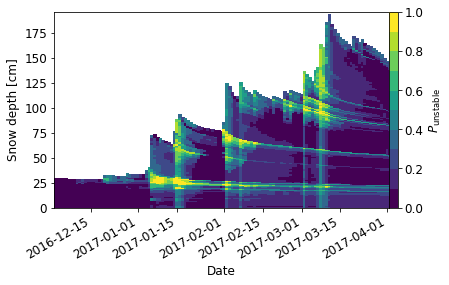

In [4]:


year = 2017
filename = '../input_example/WFJ2_2017.pro'
slopeangle = 0
start = datetime.datetime(year-1,12,1,12,0)
stop = datetime.datetime(year,4,1,12,0)

#get data from .pro 
profiles = readProfile.read_profile(filename,remove_soil=True)   # if timestamp is not given the function returns all profiles that are included in the .pro file

# create csv file with layer information and P_unstable for every day in between start and stop date 
dates = pd.date_range(start, stop, freq='D')

df_list = []
for ts in dates: 
    if ts in profiles['data'].keys():
        prof = profiles['data'][ts]        
        if (len(prof.keys()) ==0) | (len(prof['height'])==0): # no snow on the ground (empty array when soil is not computed)
            df0 = pd.DataFrame(columns = ['P_unstable', 'layer_top', 'density',
                                          'hardness', 'graintype', 'viscdefrate', 'rcflat', 'sphericity', 'grainsize',
                                          'penetrationdepth', 'slab_rhogs', 'HS'],
                                index = [0]) # 1 row filled with nan
            df0['HS'] = 0.
        else: #snow on the ground
            df0 = get_RF.create_RFprof(prof, slopeangle, model) 
            df0['HS'] = df0['layer_top'].iloc[-1]
            
        df0.insert(0,'datetime',ts)

        df_list.append(df0)
    else:
        print('date {}  not found'.format(ts))


df_evo = pd.concat(df_list, ignore_index = True)


# plot time evolution of P_unstable, P_max, depth of P_max 
var = 'P_unstable'
fig, ax = plt.subplots()
fig = plt_RF.plot_evo_SP(df_evo, fig, ax, start, stop, var, colorbar = True, resolution = 'D')
